In [4]:
# Azure Custom Vision は画像入れると勝手に NN 組んでくれる
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image
from tensorflow.keras import models, layers
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
cat_filepath = glob('data/cat/*jpg')

In [3]:
dog_filepath = glob('data/dog/*jpg')

In [5]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
x, t = [], []

for filepath in dog_filepath:
    img = Image.open(filepath)
    x.append(np.array(img))
    t.append(0)
    
for filepath in cat_filepath:
    img = Image.open(filepath)
    x.append(np.array(img))
    t.append(1)

In [7]:
len(x), len(t)

(500, 500)

In [8]:
x = np.array(x)/255
t = np.array(t)

In [9]:
x.shape

(500, 224, 224, 3)

In [10]:
t.shape

(500,)

In [11]:
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
len(x_train), len(x_val), len(t_train), len(t_val)

(350, 150, 350, 150)

In [12]:
x_train.shape

(350, 224, 224, 3)

In [13]:
x[0].shape

(224, 224, 3)

In [14]:
from tensorflow.keras.applications import VGG16

In [16]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
from tensorflow.keras import models, layers
reset_seed(0)

model = models.Sequential()

for layer in vgg16.layers:
    layer.trainable = False
    
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [22]:
optimizer = keras.optimizers.Adam(0.001)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer, metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 17,327,032
Trainable params: 2,562,168
Non-trainable params: 14,764,864
__________________________________

In [24]:
history = model.fit(x_train, t_train,
                   batch_size=128,
                   epochs=30,
                   validation_data=(x_val, t_val))

Train on 350 samples, validate on 150 samples
Epoch 1/30
350/350 [==============================] - 48s 138ms/sample - loss: 0.7409 - accuracy: 0.6714 - val_loss: 1.0133 - val_accuracy: 0.5733
Epoch 2/30
350/350 [==============================] - 47s 134ms/sample - loss: 0.0414 - accuracy: 0.9771 - val_loss: 1.0086 - val_accuracy: 0.5867
Epoch 3/30
350/350 [==============================] - 47s 134ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.9337 - val_accuracy: 0.6133
Epoch 4/30
350/350 [==============================] - 47s 134ms/sample - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8857 - val_accuracy: 0.6267
Epoch 5/30
350/350 [==============================] - 47s 134ms/sample - loss: 6.9147e-04 - accuracy: 1.0000 - val_loss: 0.8496 - val_accuracy: 0.6467
Epoch 6/30
350/350 [==============================] - 47s 134ms/sample - loss: 2.6997e-04 - accuracy: 1.0000 - val_loss: 0.8191 - val_accuracy: 0.6667
Epoch 7/30
350/350 [==============================] - 65s 187ms/

In [25]:
results = pd.DataFrame(history.history)

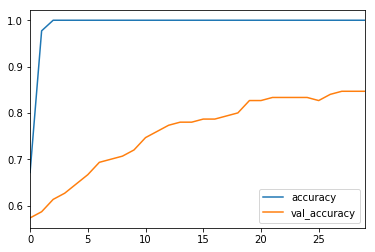

In [26]:
results[['accuracy', 'val_accuracy']].plot()